### 📂 Импорты и подготовка данных

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as transforms
import torch.nn.functional as F
import time
from collections import defaultdict
import seaborn as sns



# Проверка устройства: CPU или GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используется устройство:", device)

# Размер изображений, подходящий для MobileNetV2
IMG_SIZE = 224
BATCH_SIZE = 32
NAME_MODEL = 'meter_model+_3epoch_new_data.pth'

Используется устройство: cpu


### 🔁 Аугментации и загрузка данных

In [ ]:
# Преобразования для обучения (аугментации) и валидации/теста (только нормализация)
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Загружаем датасет
dataset_path = "./electric_meter"
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform_train)

# Разделяем на train / val / test
total_size = len(full_dataset)
train_size = int(0.95 * total_size)
val_size = int(0.03 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Меняем трансформации у валидации и теста
val_dataset.dataset.transform = transform_val
test_dataset.dataset.transform = transform_val

# Загрузчики
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Список классов
class_names = full_dataset.classes
print("Классы:", class_names)

Классы: ['legacy', 'new', 'unusable']


### 🧠 Создание модели

In [76]:
# Загружаем предобученную MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Заменяем последний слой под нашу задачу (5 классов)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_names))

# Переносим на устройство
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


c:\Users\pavel\miniconda3\envs\imgseg\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pavel\miniconda3\envs\imgseg\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 🏋️ Цикл обучения

In [ ]:
def train_model(model, train_loader, val_loader, class_names, criterion, optimizer, epochs=15):
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0

        correct_train = 0
        total_train = 0
        correct_train_per_class = defaultdict(int)
        total_train_per_class = defaultdict(int)

        all_train_preds = []
        all_train_labels = []

        # --- Обучение ---
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            for label, pred in zip(labels.cpu(), preds.cpu()):
                total_train_per_class[label.item()] += 1
                if label == pred:
                    correct_train_per_class[label.item()] += 1

            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc = correct_train / total_train

        # --- Валидация ---
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        correct_val_per_class = defaultdict(int)
        total_val_per_class = defaultdict(int)

        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

                for label, pred in zip(labels.cpu(), preds.cpu()):
                    total_val_per_class[label.item()] += 1
                    if label == pred:
                        correct_val_per_class[label.item()] += 1

                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = correct_val / total_val
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_acc)
        epoch_time = time.time() - start_time

        # === 📢 Вывод метрик ===
        print(f"\n🔁 Эпоха {epoch+1}/{epochs} | Время: {epoch_time:.1f}s")
        print(f"📉 Train Loss: {epoch_loss:.4f} | Acc: {train_acc*100:.2f}%")
        print(f"📊 Val   Loss: {val_loss:.4f} | Acc: {val_acc*100:.2f}%")

        print("\n📌 Точность по классам (TRAIN):")
        for idx, class_name in enumerate(class_names):
            correct_c = correct_train_per_class[idx]
            total_c = total_train_per_class[idx]
            acc_c = correct_c / total_c if total_c > 0 else 0
            print(f"   - {class_name:10s}: {correct_c}/{total_c} ({acc_c*100:.2f}%)")

        print("\n📌 Точность по классам (VAL):")
        for idx, class_name in enumerate(class_names):
            correct_c = correct_val_per_class[idx]
            total_c = total_val_per_class[idx]
            acc_c = correct_c / total_c if total_c > 0 else 0
            print(f"   - {class_name:10s}: {correct_c}/{total_c} ({acc_c*100:.2f}%)")

        # === 📈 Classification report ===
        print("\n📄 Classification Report (Validation):")
        print(classification_report(all_val_labels, all_val_preds, target_names=class_names, digits=3))

        # === 🧩 Матрица ошибок ===
        cm = confusion_matrix(all_val_labels, all_val_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"Confusion Matrix - Epoch {epoch+1}")
        plt.tight_layout()
        plt.show()

    return train_loss_history, val_loss_history, val_accuracy_history



🔁 Эпоха 1/3 | Время: 203.3s
📉 Train Loss: 0.2424 | Acc: 91.55%
📊 Val   Loss: 0.0493 | Acc: 98.04%

📌 Точность по классам (TRAIN):
   - legacy    : 473/519 (91.14%)
   - new       : 522/544 (95.96%)
   - unusable  : 501/571 (87.74%)

📌 Точность по классам (VAL):
   - legacy    : 13/13 (100.00%)
   - new       : 17/17 (100.00%)
   - unusable  : 20/21 (95.24%)

📄 Classification Report (Validation):
              precision    recall  f1-score   support

      legacy      1.000     1.000     1.000        13
         new      0.944     1.000     0.971        17
    unusable      1.000     0.952     0.976        21

    accuracy                          0.980        51
   macro avg      0.981     0.984     0.982        51
weighted avg      0.981     0.980     0.980        51



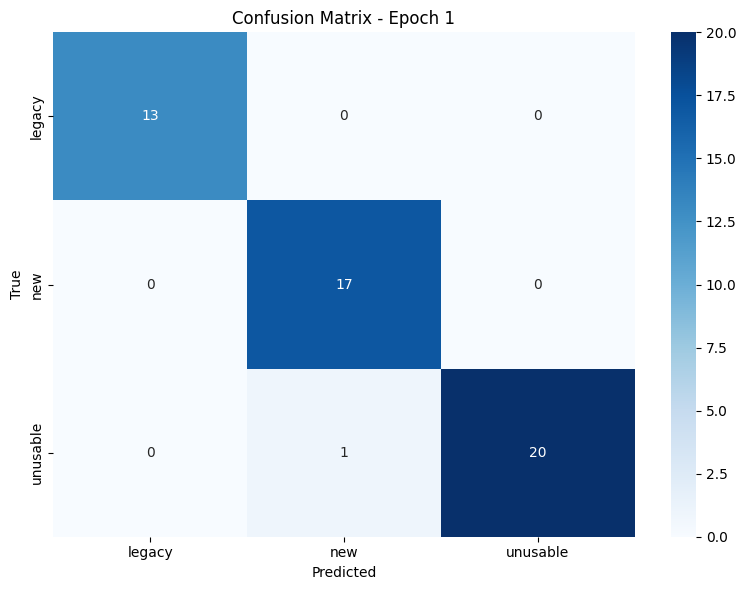


🔁 Эпоха 2/3 | Время: 204.1s
📉 Train Loss: 0.0507 | Acc: 98.53%
📊 Val   Loss: 0.0095 | Acc: 100.00%

📌 Точность по классам (TRAIN):
   - legacy    : 512/519 (98.65%)
   - new       : 541/544 (99.45%)
   - unusable  : 557/571 (97.55%)

📌 Точность по классам (VAL):
   - legacy    : 13/13 (100.00%)
   - new       : 17/17 (100.00%)
   - unusable  : 21/21 (100.00%)

📄 Classification Report (Validation):
              precision    recall  f1-score   support

      legacy      1.000     1.000     1.000        13
         new      1.000     1.000     1.000        17
    unusable      1.000     1.000     1.000        21

    accuracy                          1.000        51
   macro avg      1.000     1.000     1.000        51
weighted avg      1.000     1.000     1.000        51



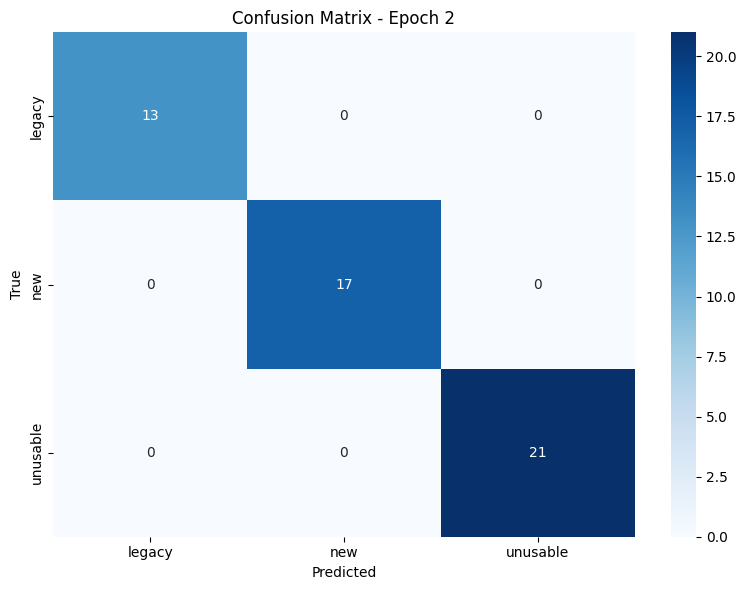


🔁 Эпоха 3/3 | Время: 203.2s
📉 Train Loss: 0.0237 | Acc: 99.45%
📊 Val   Loss: 0.0043 | Acc: 100.00%

📌 Точность по классам (TRAIN):
   - legacy    : 515/519 (99.23%)
   - new       : 542/544 (99.63%)
   - unusable  : 568/571 (99.47%)

📌 Точность по классам (VAL):
   - legacy    : 13/13 (100.00%)
   - new       : 17/17 (100.00%)
   - unusable  : 21/21 (100.00%)

📄 Classification Report (Validation):
              precision    recall  f1-score   support

      legacy      1.000     1.000     1.000        13
         new      1.000     1.000     1.000        17
    unusable      1.000     1.000     1.000        21

    accuracy                          1.000        51
   macro avg      1.000     1.000     1.000        51
weighted avg      1.000     1.000     1.000        51



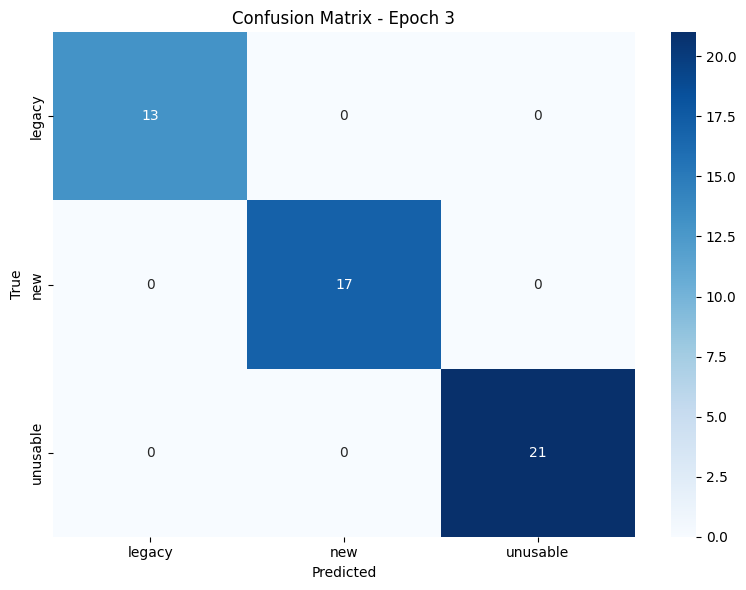

In [78]:
train_loss, val_loss, val_acc = train_model(model, train_loader, val_loader, class_names, criterion, optimizer, epochs=3)

### 📈 Визуализация обучения

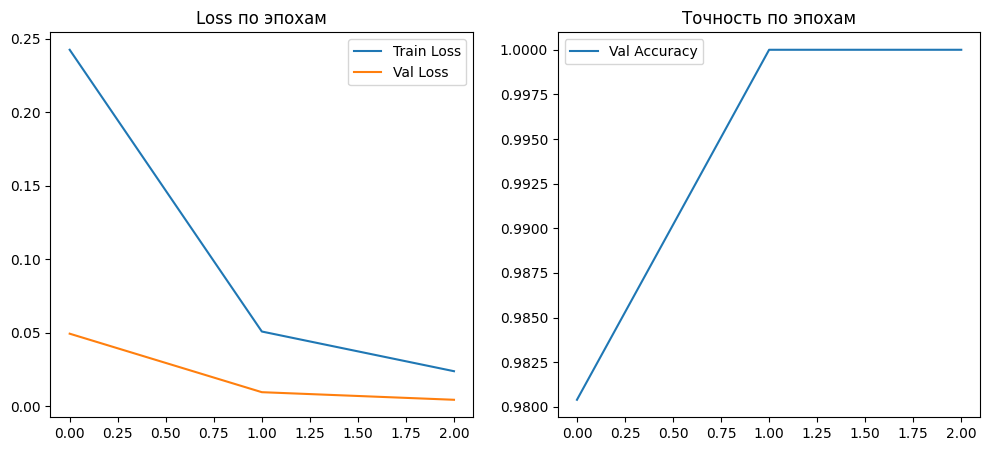

In [79]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss по эпохам')

plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.title('Точность по эпохам')

plt.show()

### 🧪 Оценка на тесте

Classification Report:

              precision    recall  f1-score   support

      legacy       1.00      1.00      1.00        13
         new       1.00      1.00      1.00        10
    unusable       1.00      1.00      1.00        13

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



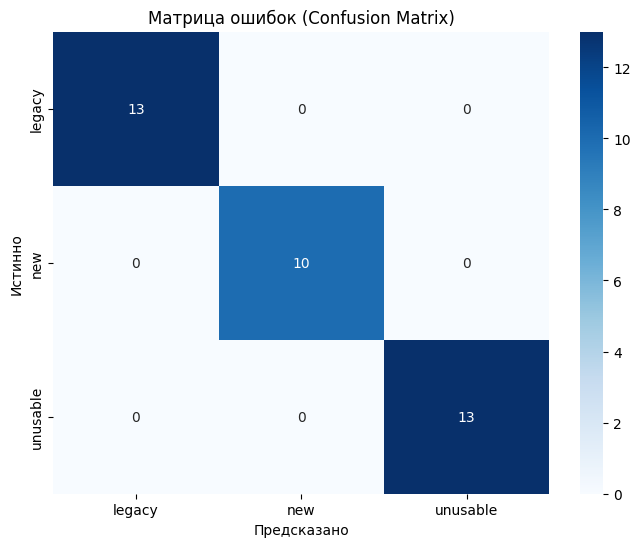

In [80]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Отчёт по метрикам
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Матрица ошибок
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Предсказано")
plt.ylabel("Истинно")
plt.title("Матрица ошибок (Confusion Matrix)")
plt.show()

### 💾 Сохранение модели

In [81]:
# Сохраняем модель и словарь классов
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names
}, NAME_MODEL)

print(f"Модель сохранена в {NAME_MODEL}")

Модель сохранена в meter_model+_3epoch_new_data.pth


### 📷 Инференс на 1 фото

In [20]:

# Загружаем модель и классы
checkpoint = torch.load(NAME_MODEL, map_location=device)

# Загружаем MobileNetV2 и подменяем последний слой
model = models.mobilenet_v2(pretrained=False)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(checkpoint['class_names']))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

class_names = checkpoint['class_names']

# Предобработка изображения (аналогичная валидации)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# 🔍 Функция инференса на одном изображении
def predict_image(img_path):
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
        class_name = class_names[class_idx]

    print(f"📸 Файл: {img_path}")
    print(f"🔮 Предсказано: {class_name}")
    return class_name

# Пример использования
#predict_image("sample.jpg")  # замените на путь к вашему файлу


C:\Users\pavel\AppData\Local\Temp\ipykernel_17536\661224714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(NAME_MODEL, map_location=device)
c:\U

📸 Файл: sample\9.jpeg
🔮 Предсказано: legacy


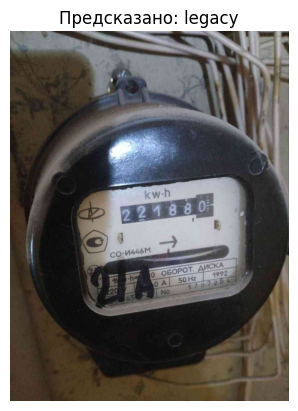

In [ ]:
import matplotlib.pyplot as plt

def show_prediction(img_path):
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.axis('off')
    pred_class = predict_image(img_path)
    plt.title(f"Предсказано: {pred_class}")
    plt.show()

# Вызов
show_prediction("sample\9.jpeg")


### 📦 Полный скрипт: Инференс по всем изображениям в папке sample/

In [ ]:
# Папка с изображениями
sample_folder = "sample"
image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".webp"]

# Предобработка такая же, как при обучении
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet
                         [0.229, 0.224, 0.225])
])

# Функция предсказания с вероятностями
def predict_image(img_path):
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1).squeeze()
        predicted_idx = torch.argmax(probs).item()
        predicted_label = class_names[predicted_idx]
        confidence = probs[predicted_idx].item()

    return predicted_label, confidence, probs.cpu().numpy()

# === Инференс всех файлов в папке ===
for filename in sorted(os.listdir(sample_folder)):
    if any(filename.lower().endswith(ext) for ext in image_extensions):
        img_path = os.path.join(sample_folder, filename)
        pred_label, confidence, all_probs = predict_image(img_path)

        # Визуализация
        img = Image.open(img_path).convert('RGB')
        plt.figure(figsize=(6, 4))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{filename} ➜ {pred_label} ({confidence*100:.2f}%)", fontsize=14)
        plt.tight_layout()
        plt.show()

        # Подробный вывод
        print(f"📂 Файл: {filename}")
        print(f"🖼️ Размер: {img.size}")
        print(f"🔮 Предсказано: {pred_label} ({confidence*100:.2f}%)")
        print("📊 Уверенность по всем классам:")
        for i, class_name in enumerate(class_names):
            print(f"   - {class_name:10s}: {all_probs[i]*100:.2f}%")
        print("-" * 40)